# XGBoost Classifier

## Clean and Pull Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('hate_speech_training.csv')
df_train_2 = pd.read_csv('hate_speech_training_2.csv')
df_train_3 = pd.read_csv('hate_speech_training_3.csv')
df_train_4 = pd.read_csv('hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [27]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Pipeline for TF-IDF on XGBoost

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [18]:
tfidf_xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1))
])

In [20]:
tfidf_xgb_pipe.fit(token_docs, y_train)

[00:52:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [21]:
tfidf_xgb_pipe.score(X_train, y_train)

0.7863798375278175

In [17]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(tfidf_xgb_pipe, X_train, y_train, cv = 5)

[00:58:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:00:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:01:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.91849842, 0.91677221, 0.91984802, 0.9191243 , 0.9206622 ])

In [24]:
tfidf_xgb_pipe.score(X_test, y_test)

0.7993920972644377

In [18]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

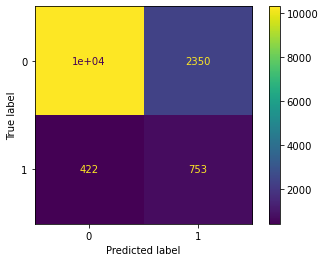

In [26]:
plot_confusion_matrix(tfidf_xgb_pipe, X_test, y_test)

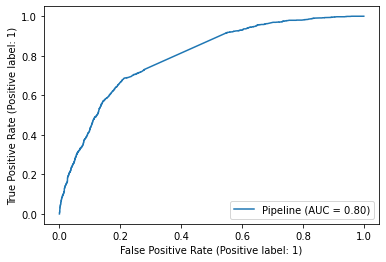

In [27]:
plot_roc_curve(tfidf_xgb_pipe, X_test, y_test)

In [28]:
y_hat = tfidf_xgb_pipe.predict(X_test)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     12643
           1       0.24      0.64      0.35      1175

    accuracy                           0.80     13818
   macro avg       0.60      0.73      0.62     13818
weighted avg       0.90      0.80      0.84     13818



## Grid Search on TF-IDF and XGBoost Pipeline

In [19]:
tfidf_xgb_params = {
    'tfidf__max_features':[None, 20_000, 1_000],
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'xgb__max_depth':[3,4,5],
    'SMOTE__sampling_strategy':['auto', 0.75, 0.90]
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [ ]:
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,
                            param_grid=tfidf_xgb_params, 
                            cv = 3, 
                            verbose = 3,
                           n_jobs = -1)

In [28]:
gs_tfidf_xgb.fit(token_docs, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[07:27:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                    

In [29]:
gs_tfidf_xgb.best_score_

0.9216768345577204

In [30]:
gs_tfidf_xgb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [31]:
gs_tfidf_xgb.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (2, 2),
 'xgb__max_depth': 5}

# Best XGBoost Model on TFIDF

In [32]:
tfidf_best_xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (2, 2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1, max_depth = 5))
])

In [33]:
tfidf_best_xgb_pipe.fit(token_docs, y_train)

[13:23:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [34]:
tfidf_best_xgb_pipe.score(token_docs, y_train)

0.9322610410522697

In [35]:
cross_val_score(tfidf_best_xgb_pipe, token_docs, y_train, cv = 5)

[13:24:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.92284034, 0.92129546, 0.92102406, 0.92482359, 0.92048127])

In [36]:
tfidf_best_xgb_pipe.score(test_token_docs, y_test)

0.9243016355478362

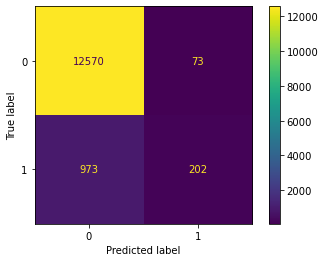

In [37]:
plot_confusion_matrix(tfidf_best_xgb_pipe, test_token_docs, y_test)

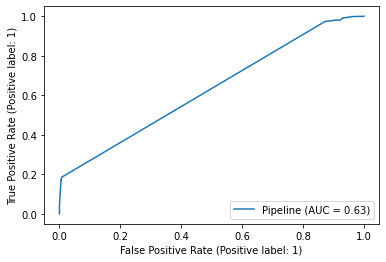

In [38]:
plot_roc_curve(tfidf_best_xgb_pipe, test_token_docs, y_test)

In [39]:
y_hat_2 = tfidf_best_xgb_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.73      0.17      0.28      1175

    accuracy                           0.92     13818
   macro avg       0.83      0.58      0.62     13818
weighted avg       0.91      0.92      0.90     13818



## Grid Search for Count Vectorizer on XGBoost Classifier

In [40]:
cv_xgb_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1))
])

In [41]:
cv_xgb_pipe.fit(token_docs, y_train)

[13:31:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [43]:
cv_xgb_params = {
    'cv__max_features':[None, 20_000, 1_000],
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'xgb__max_depth':[3,4,5],
    'SMOTE__sampling_strategy':['auto', 0.75, 0.90]
}

In [43]:
gs_cv_xgb = GridSearchCV(cv_xgb_pipe,
                            param_grid=cv_xgb_params, 
                            cv = 3, 
                            verbose = 3,
                           n_jobs = -1)

In [44]:
gs_cv_xgb.fit(token_docs, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[14:24:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                

In [45]:
gs_cv_xgb.best_score_

0.9245897637015634

In [46]:
gs_cv_xgb.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [47]:
gs_cv_xgb.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2),
 'xgb__max_depth': 5}

## Best XGBoost Model with Count Vectorizer

In [48]:
cv_best_xgb_pipe = Pipeline([
    ('cv', CountVectorizer(max_features = None, ngram_range = (1,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1, max_depth = 5))
])

In [ ]:
cv_best_xgb_pipe.fit(token_docs, y_train)

[14:32:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [ ]:
cv_best_xgb_pipe.score(token_docs, y_train)

0.9274483906569448

In [51]:
cross_val_score(cv_best_xgb_pipe, token_docs, y_train, cv = 5)

[14:33:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:35:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.92473994, 0.92147639, 0.92419034, 0.9245522 , 0.92672336])

In [52]:
cv_best_xgb_pipe.score(test_token_docs, y_test)

0.925531914893617

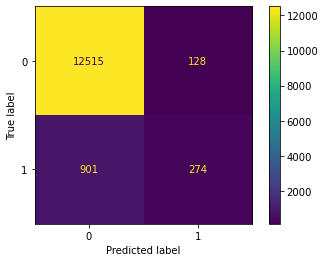

In [53]:
plot_confusion_matrix(cv_best_xgb_pipe, test_token_docs, y_test)

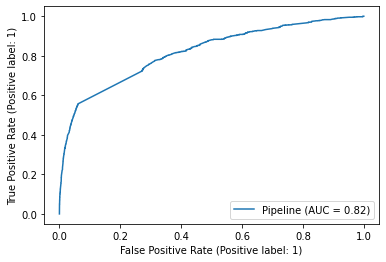

In [54]:
plot_roc_curve(cv_best_xgb_pipe, test_token_docs, y_test)

In [55]:
y_hat_3 = cv_best_xgb_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.68      0.23      0.35      1175

    accuracy                           0.93     13818
   macro avg       0.81      0.61      0.65     13818
weighted avg       0.91      0.93      0.91     13818



## NLP Cleanup ONLY Words (No # or @)

In [21]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [22]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## Pipeline Grid Search for XGBoost on TFIDF

In [23]:
tfidf_xgb_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1))
])

In [24]:
tfidf_xgb_pipe_2.fit(token_docs_2, y_train)

[19:54:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [25]:
gs_tfidf_xgb_2 = GridSearchCV(tfidf_xgb_pipe_2,
                            param_grid=tfidf_xgb_params, 
                            cv = 3, 
                            verbose = 3,
                           n_jobs = -1)

In [26]:
gs_tfidf_xgb_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[23:10:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                             

In [27]:
gs_tfidf_xgb_2.best_score_

0.9218758611368153

In [28]:
gs_tfidf_xgb_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [29]:
gs_tfidf_xgb_2.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (2, 2),
 'xgb__max_depth': 3}

## Best XGBoost Model / TFIDF

In [30]:
tfidf_best_xgb_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (2,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1, max_depth = 3))
])

In [31]:
tfidf_best_xgb_pipe_2.fit(token_docs_2, y_train)

[23:24:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [32]:
tfidf_best_xgb_pipe_2.score(token_docs_2, y_train)

0.9277559660581498

In [33]:
cross_val_score(tfidf_best_xgb_pipe_2, token_docs_2, y_train, cv = 5)

[23:24:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.92157395, 0.92210964, 0.92057174, 0.92409987, 0.9224715 ])

In [34]:
tfidf_best_xgb_pipe_2.score(test_token_docs_2, y_test)

0.9237950499348676

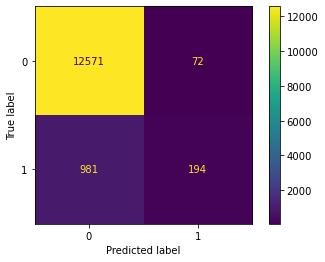

In [36]:
plot_confusion_matrix(tfidf_best_xgb_pipe_2, test_token_docs_2, y_test)

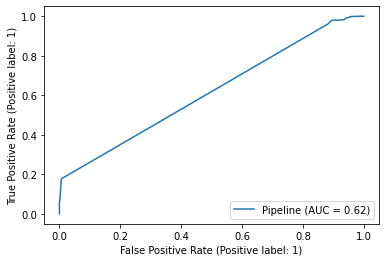

In [39]:
plot_roc_curve(tfidf_best_xgb_pipe_2, test_token_docs_2, y_test)

In [37]:
y_hat_4 = tfidf_best_xgb_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.73      0.17      0.27      1175

    accuracy                           0.92     13818
   macro avg       0.83      0.58      0.61     13818
weighted avg       0.91      0.92      0.90     13818



## Pipeline Grid Search for XGBoost Model on Count Vectorizer

In [40]:
cv_xgb_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1))
])

In [41]:
cv_xgb_pipe_2.fit(token_docs_2, y_train)

[23:27:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [44]:
gs_cv_xgb_2 = GridSearchCV(cv_xgb_pipe_2,
                            param_grid=cv_xgb_params, 
                            cv = 3, 
                            verbose = 3,
                           n_jobs = -1)

In [45]:
gs_cv_xgb_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[01:20:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                

In [46]:
gs_cv_xgb_2.best_score_

0.9249516194064373

In [47]:
gs_cv_xgb_2.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [48]:
gs_cv_xgb_2.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2),
 'xgb__max_depth': 5}

## Best XGBoost Model with Count Vectorizer

In [49]:
cv_best_xgb_pipe_2 = Pipeline([
    ('cv', CountVectorizer(max_features = None, ngram_range = (1,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('xgb', XGBClassifier(n_jobs = -1, verbosity = 1, max_depth = 5))
])

In [50]:
cv_best_xgb_pipe_2.fit(token_docs_2, y_train)

[01:25:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [51]:
cv_best_xgb_pipe_2.score(token_docs_2, y_train)

0.9274302979862857

In [52]:
cross_val_score(cv_best_xgb_pipe_2, token_docs_2, y_train, cv = 5)

[01:25:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:27:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.92654907, 0.92283336, 0.92446173, 0.92509499, 0.92627103])

In [53]:
cv_best_xgb_pipe_2.score(test_token_docs_2, y_test)

0.9278477348386163

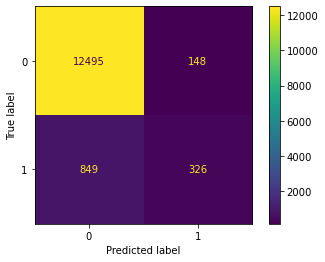

In [54]:
plot_confusion_matrix(cv_best_xgb_pipe_2, test_token_docs_2, y_test)

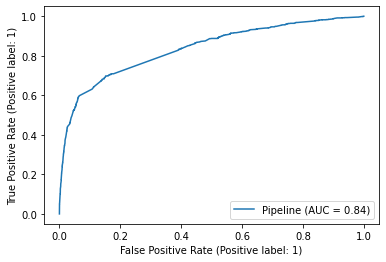

In [55]:
plot_roc_curve(cv_best_xgb_pipe_2, test_token_docs_2, y_test)

In [56]:
y_hat_5 = cv_best_xgb_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12643
           1       0.69      0.28      0.40      1175

    accuracy                           0.93     13818
   macro avg       0.81      0.63      0.68     13818
weighted avg       0.92      0.93      0.91     13818

